# Regression Analysis and Hypothesis Test
@Yu-Wei Hsu

# Import libraries

In [ ]:
import numpy as np
import pandas as pd
import os
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from numpy.random import seed
from numpy.random import randn
from scipy.stats import f_oneway

In [ ]:
# Set the graph size
plt.style.use('seaborn-pastel')
plt.rcParams["figure.figsize"] = (24,8)

# Part 1: Regression Analysis

## EDA

### Acquire data


In [ ]:
# Read the data from google sheet
path = "https://docs.google.com/spreadsheets/d/e/2PACX-1vQEqNw-bwRG_I_OpxTG30LPxhr68wk9pfuYSGFKXMB1F2vu3-2Xg_Dtu6W-TiEfE0vXQvlLLbVGfipZ/pub?gid=475244513&single=true&output=csv"
df = pd.read_csv(path,index_col="id")
print('shape: 'df.shape)

In [ ]:
# Brief look into data
#df.head(n=5)

### Light modifications

In [ ]:
# Check data type and NaN values for each feature
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3974 entries, 3363954 to 18182089
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   country                 3974 non-null   object 
 1   state                   3781 non-null   object 
 2   neighbourhood_cleansed  3974 non-null   object 
 3   property_type           3974 non-null   object 
 4   square_meters           3974 non-null   float64
 5   price                   3974 non-null   object 
 6   room_type               3974 non-null   object 
 7   bathrooms               3969 non-null   float64
 8   bedrooms                3972 non-null   float64
 9   beds                    3973 non-null   float64
dtypes: float64(4), object(6)
memory usage: 341.5+ KB


- There are Null values in the state, bedrooms and beds columns.
- The data type of price is object, which should be stored as the numerical data type.
- Remove the outliers.


In [ ]:
# Drop na
df = df.dropna()

# Convert data type of price to float
df['price'] = df['price'].str.replace(r'[,$]', '').astype(float)

# Remove outliers
"""
q1 = df['price'].quantile(0.25)
q3 = df['price'].quantile(0.75)
iqr = q3-q1
lower_bound = q1 - 1.5*iqr
upper_bound = q3 + 1.5*iqr
"""
lower_bound = df['price'].quantile(.01)
upper_bound = df['price'].quantile(.99)
df_trimmed = df[(df.price > lower_bound) & (df.price < upper_bound)]

### Description of quantitative variables

In [ ]:
df_trimmed.describe()

,square_meters,price,bathrooms,bedrooms,beds
count,3694.000000,3694.000000,3694.000000,3694.000000,3694.000000
mean,31.805782,761.015160,1.611668,2.221982,2.929074
std,11.788761,732.836937,0.818598,1.356551,1.977494
min,0.000000,53.000000,0.000000,0.000000,0.000000
25%,24.535000,194.000000,1.000000,1.000000,1.000000
50%,29.400000,524.500000,1.000000,2.000000,3.000000
75%,33.980000,1100.000000,2.000000,3.000000,4.000000
max,208.700000,3990.000000,9.000000,12.000000,18.000000


### Description of qualitative variables

In [ ]:
df_trimmed[['country','state','neighbourhood_cleansed','property_type','room_type']].describe()

,country,state,neighbourhood_cleansed,property_type,room_type
count,3694,3694,3694,3694,3694
unique,1,8,5,8,3
top,Australia,NSW,BYRON SHIRE COUNCIL,House,Entire home/apt
freq,3694,3526,2408,2260,2986


- There are eight unique values in the state; while there are six states in Australia, we could investigate more on the state column.
- Byron Shire Council is the most popular one among the five neighborhoods with the largest frequency.

In [ ]:
# Take a look in the state column
df_trimmed['state'].unique()

array(['NSW', 'New South Wales', 'Nsw', 'nsw', 'QLD', 'Queensland',
       'queensland', 'Qld'], dtype=object)

In [ ]:
# Name list of property_type
df_trimmed['property_type'].unique()

array(['House', 'Guest suite', 'Guesthouse', 'Apartment', 'Camper/RV',
       'Loft', 'Other', 'Nature lodge'], dtype=object)

- There are actually only two states in this feature, New South Wales and Queensland. We could change the name to each related group.
- Also combine the 'Guest suite' and 'Guesthouse.'
- Then, count the frequencies.

In [ ]:
# Combine names for related values
df_trimmed['state'].loc[df_trimmed['state'].isin(['New South Wales', 'Nsw', 'nsw'])]='NSW'
df_trimmed['state'].loc[df_trimmed['state'].isin(['Queensland', 'queensland', 'Qld'])]='QLD'
df_trimmed['property_type'].loc[df_trimmed['property_type'].isin(['Guesthouse'])]='Guest suite'

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid d

In [ ]:
# Count the frequency of the sate
df_trimmed_state = df_trimmed.groupby('state').size().reset_index(name='counts')
df_trimmed_state

,state,counts
0,NSW,3646
1,QLD,48


In [ ]:
# Count the frequency of the neighbourhood_cleansed
df_trimmed_nh = df_trimmed.groupby('neighbourhood_cleansed').size().reset_index(name='counts')
df_trimmed_nh

,neighbourhood_cleansed,counts
0,BALLINA SHIRE COUNCIL,418
1,BYRON SHIRE COUNCIL,2408
2,LISMORE CITY COUNCIL,111
3,RICHMOND VALLEY COUNCIL,18
4,TWEED SHIRE COUNCIL,739


In [ ]:
# Count the frequency of the property_types
df_trimmed_pt = df_trimmed.groupby('property_type').size().reset_index(name='counts')
df_trimmed_pt

,property_type,counts
0,Apartment,853
1,Camper/RV,42
2,Guest suite,474
3,House,2260
4,Loft,23
5,Nature lodge,23
6,Other,19


### Data Visualization (Box plot and scatter plot)


Take the larger proportion values from each feature and create the box plot

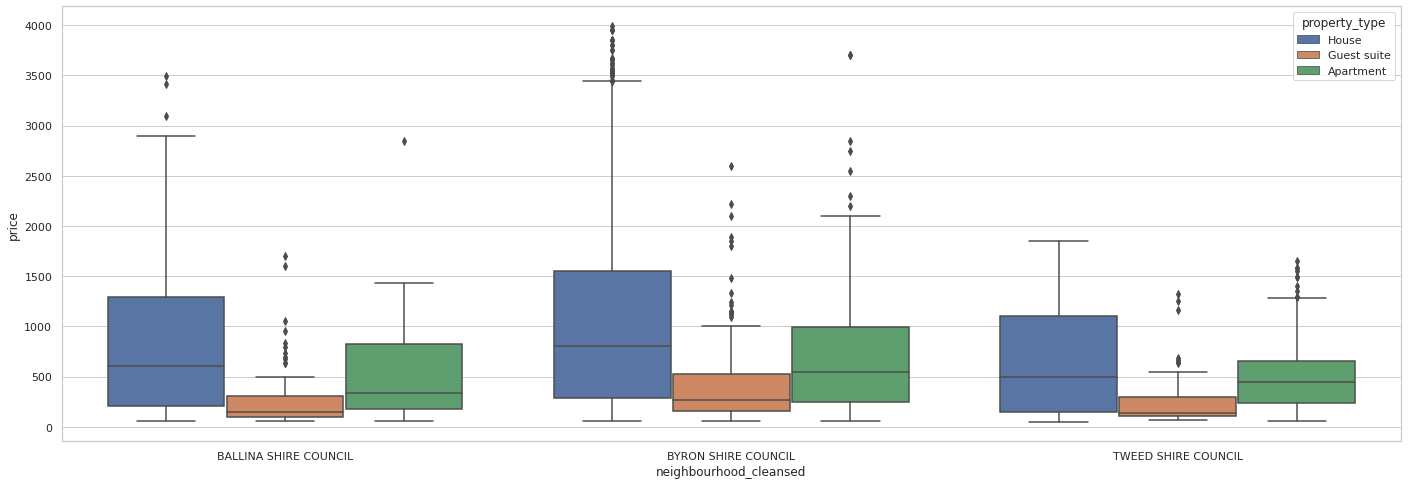

In [ ]:
# Choose the larger proportion values from neighbourhood_cleansed and property_type
df_trimmed_box = df_trimmed.loc[(df_trimmed['neighbourhood_cleansed'].isin(['BYRON SHIRE COUNCIL','BALLINA SHIRE COUNCIL','TWEED SHIRE COUNCIL']))]
df_trimmed_box = df_trimmed_box.loc[(df_trimmed_box['property_type'].isin(['House','Apartment','Guest suite']))]

# Draw a boxplot of price from each neighbourhood_cleansed cut by property_type
sns.set(style='whitegrid')
ax = sns.boxplot(y='price', x = 'neighbourhood_cleansed', hue='property_type', data = df_trimmed_box)

- Scatter plots of square_meters and price for each neighbourhood_cleansed

(0.0, 4000.0)

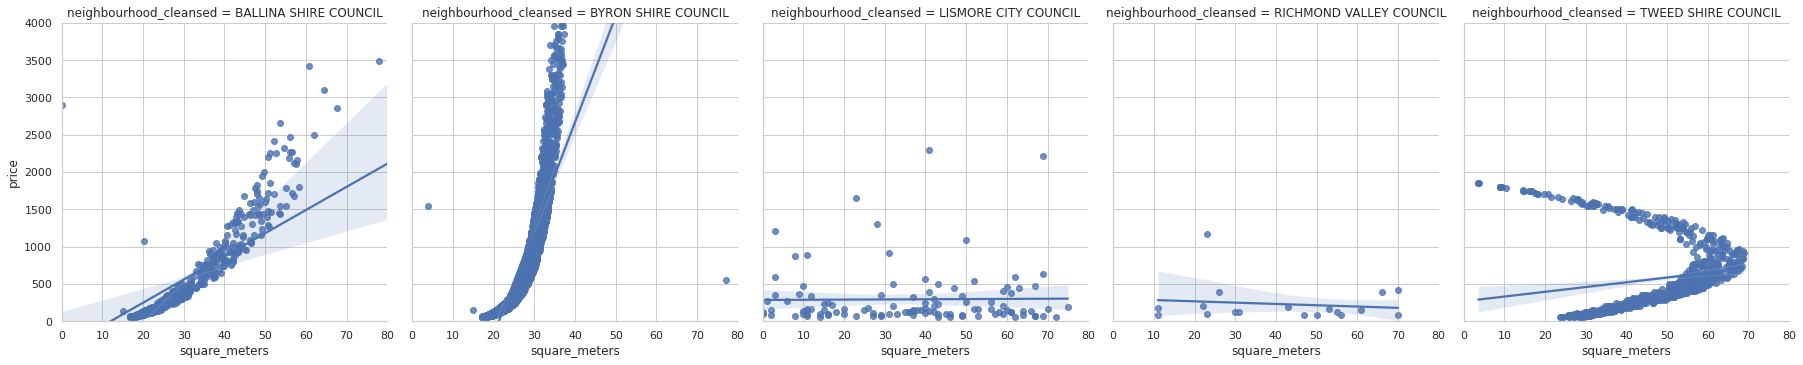

In [ ]:
# Draw the scatter plots for each neighbourhood_cleansed
ax = sns.lmplot(x = 'square_meters', y = 'price', col = 'neighbourhood_cleansed', data = df_trimmed)
plt.xlim([0,80])
plt.ylim([0,4000])

### Select specific area in each cloumn to apply regression analysis
- Drop the columns that are not necessary, such as country and state.
- (BALLINA SHIRE COUNCIL neighborhood, which is located in NSW state, there is only one value in the state, so no need to keep state column.)
- Select the specific area for neighbourhood_cleansed, property_type, and room_type.

In [ ]:
# Drop "country" and "state"columns
df_trimmed = df_trimmed.drop(columns=["country","state"])

# Filter specific area
df_filtered = df_trimmed.loc[df_trimmed.neighbourhood_cleansed == 'BALLINA SHIRE COUNCIL']
df_filtered = df_filtered.loc[df_filtered.property_type == 'House']
df_filtered = df_filtered.loc[df_filtered.room_type == 'Entire home/apt'] 
df_filtered.shape

(187, 8)

In [ ]:
#df_filtered.head(n=5)

## Regression approach

### Scatter plot and regression line of selected data

Text(0.5, 1.0, 'Square Meters vs Price')

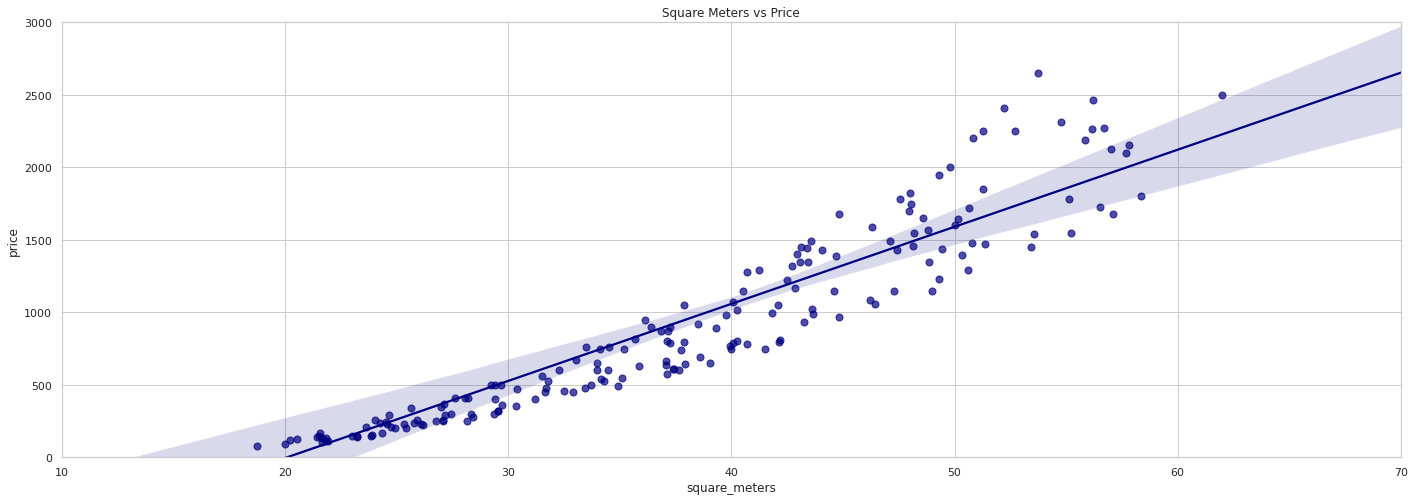

In [ ]:
# Draw the original scatter plot of filtered data
ax = sns.regplot(x = 'square_meters', y = 'price', color = 'navy', data = df_filtered, scatter_kws={'s':50,'alpha':0.7})
plt.xlim([10,70])
plt.ylim([0,3000])
plt.title('Square Meters vs Price')

### Split into train and test datasets, then create a linear regression model

In [ ]:
# Set the independent and dependent variables
X_cols = ['square_meters']
X = df_filtered[X_cols].values
y = df_filtered['price'].values

# Reshape dataset
row_length = len(df_filtered)
column_length = len(df_filtered[X_cols].columns)
X = X.reshape(row_length,column_length)
y = y.reshape(row_length,1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

# Linear regression models
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Predictions
listing_y_pred = lin_reg.predict(X_test)

### Results from the linear regression
- Predictions
- Intercept
- Slope (Coefficient)
- **Prediction(Y) = intercept + slope * X( independent variable) + error**
- Mean Squre Error (MSE)
- Variance Score (R^2)





In [ ]:
# Predictions from test dataset
print('Predictions:')
print((pd.DataFrame(listing_y_pred, columns={'y_prediction'}).head(5)))

# Intercept
print('\nIntercept:', float(lin_reg.intercept_))


# Coefficient
print('\nCoefficient(Slope):')
coeff_df = pd.DataFrame(lin_reg.coef_)
coeff_df.columns = X_cols
print(coeff_df)

print('\nPerformance:')
# MSE & RMSE
print("Mean Squared Error (MSE):%.2f" % mean_squared_error(y_test, listing_y_pred))
print("Square Root of MSE (RMSE):%.2f" % np.sqrt(mean_squared_error(y_test, listing_y_pred)))

# Variance score(R^2):
print('Variance Score (R^2):%.2f' % r2_score(y_test, listing_y_pred))

Predictions:
   y_prediction
0   2295.433792
1    750.632575
2    807.266858
3   1457.044130
4   1204.718170

Intercept: -967.1054728222618

Coefficient(Slope):
   square_meters
0      50.566325

Performance:
Mean Squared Error (MSE):59821.40
Square Root of MSE (RMSE):244.58
Variance Score (R^2):0.89


### Fit the regression line on the plot using X values of test dataset and predict values y.

(0.0, 3000.0)

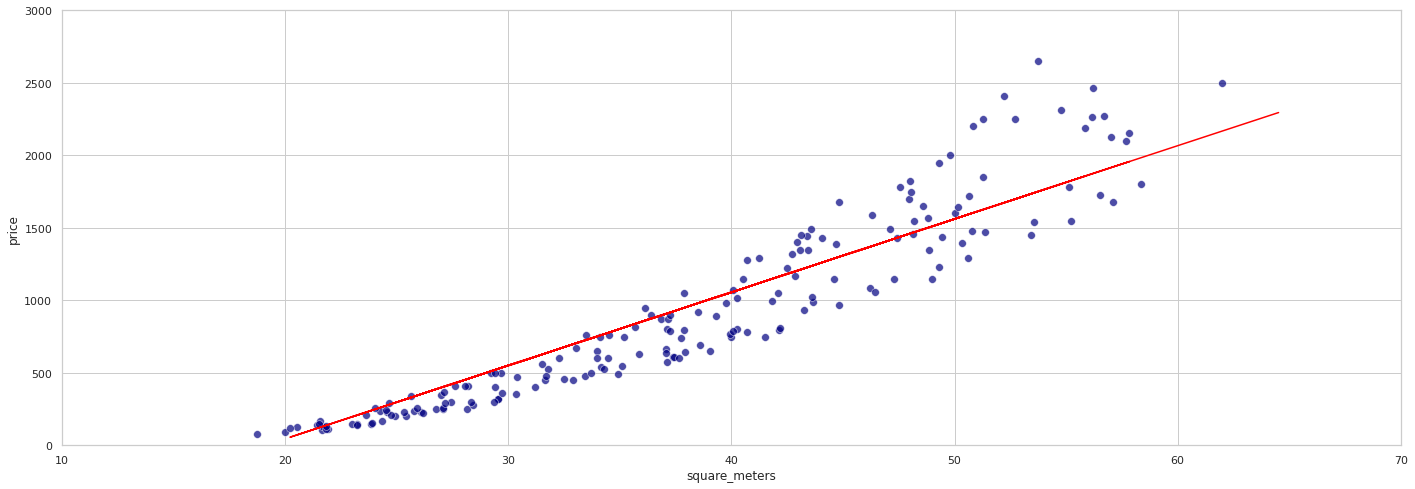

In [ ]:
# Draw the scatter plot of filtered data fitting the prediction
ax = sns.scatterplot(x = 'square_meters', y = 'price', color = 'navy', data = df_filtered, s=60, alpha=0.7)
plt.plot(X_test, listing_y_pred, color='red')
plt.xlim([10,70])
plt.ylim([0,3000])

### Test multiple features for better predcition
- To see whether we get better performance after adding more variable to calculate.

In [ ]:
# Add bathroom and beds into consideration
X_cols2 = ['square_meters', 'bathrooms', 'beds']
X2 = df_filtered[X_cols2].values
y2 = df_filtered['price'].values

# Reshape dataset
row_length2 = len(df_filtered)
column_length2 = len(df_filtered[X_cols2].columns)
X2 = X2.reshape(row_length2,column_length2)
y2 = y2.reshape(row_length2,1)

# Split the data into training and testing sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, random_state = 42)

# Linear regression models
lin_reg2= LinearRegression()
lin_reg2.fit(X_train2, y_train2)

# Predictions
listing_y_pred2 = lin_reg2.predict(X_test2)

Results from adding multiple features

In [ ]:
# Predictions from test dataset
print('Predictions:')
print((pd.DataFrame(listing_y_pred2, columns={'y_prediction'}).head(5)))

# Intercept
print('\nIntercept:', float(lin_reg2.intercept_))

# Coefficient
print('\nCoefficient(Slope):')
coeff_df2 = pd.DataFrame(lin_reg2.coef_)
coeff_df2.columns = X_cols2
print(coeff_df2)

print('\nPerformance:')
# MSE & RMSE
print("Mean Squared Error (MSE):%.2f" % mean_squared_error(y_test2, listing_y_pred2))
print("Square Root of MSE (RMSE):%.2f" % np.sqrt(mean_squared_error(y_test2, listing_y_pred2)))

# Variance score(R^2):
print('Variance Score (R^2):%.2f' % r2_score(y_test2, listing_y_pred2))

Predictions:
   y_prediction
0   2419.896095
1    756.134388
2    966.273847
3   1373.955361
4   1150.704041

Intercept: -1051.3087651990606

Coefficient(Slope):
   square_meters  bathrooms      beds
0      43.630531  158.50578  2.767485

Performance:
Mean Squared Error (MSE):64145.06
Square Root of MSE (RMSE):253.27
Variance Score (R^2):0.88


## Finding:
- Pricing in BYRON SHIRE COUNCIL is higher than other neighborhoods among most property types. (Observed from boxplot)
- Using the linear regression model to predict the relationship between square_meters and price, we got Square Root of Mean Squared Error(RMSE) is 244.58, and Variance Score (R^2) is 0.89.
- Applying multiple variables into linear regression, the RMSE is 253.27, and the R^2 is 0.88, which does not improve prediction performance.
- After exploring the data
  - I feel comfortable recommending the BALLINA SHIRE COUNCIL neighborhood price with the linear regression model, which explains 89% variability of observed data around its mean. 
  - Least comfortable providing price recommendation in TWEED SHIRE COUNCIL neighborhood, since the price ranges widely within 30 to 50 square meters. (Observed from scatter plots shown five neighborhoods)
- We need more records for LISMORE CITY COUNCIL and RICHMOND VALLEY COUNCIL to find better solutions to predict the price in these two neighborhoods.


# Part 2: Hypothesis Test

### Acquire data

In [ ]:
# Read data from google spreadsheet
path_s = "https://docs.google.com/spreadsheets/d/e/2PACX-1vT11RfrD5zv7_BEcu5Fd1is2gBYGRZGbXt2nWivN-IqaLCjPumtWRvWb9CIHPenWpBo9ww7WgPpNVW0/pub?gid=1347438997&single=true&output=csv"
path_l = "https://docs.google.com/spreadsheets/d/e/2PACX-1vT11RfrD5zv7_BEcu5Fd1is2gBYGRZGbXt2nWivN-IqaLCjPumtWRvWb9CIHPenWpBo9ww7WgPpNVW0/pub?gid=464773015&single=true&output=csv"
df_sfo = pd.read_csv(path_s)
df_lax = pd.read_csv(path_l)

In [ ]:
df_sfo.head(n=5)

,Date,SFO - Avg. Daily Miles Driven Per Hour,Marketing_Campaign
0,09/14/2019,51.673648,0
1,09/15/2019,53.993709,0
2,09/16/2019,40.051560,0
3,09/17/2019,78.805715,0
4,09/18/2019,73.056075,0


In [ ]:
df_lax.tail(n=5)

,Date,LAX - Avg. Daily Miles Driven Per Hour,Marketing_Campaign
98,12/21/2019,226.186343,1
99,12/22/2019,269.804260,1
100,12/23/2019,124.325986,1
101,12/24/2019,158.896094,0
102,12/25/2019,237.726007,0


### Test setup:
- The Null hypothesis is that the average daily miles driven per hour when there is a marketing campaign is the same as the average daily miles driven per hour while there is no marketing campaign.
- The Alternative hypothesis is that the average daily miles driven per hour with the marketing campaign is greater than the average daily miles driven per hour while there is no marketing campaign.
- The significant level is set to 95%, and the p-value is set to 0.05.

## SFO Dataset 


### Description of quantitative variables

In [ ]:
df_sfo.describe()

,SFO - Avg. Daily Miles Driven Per Hour,Marketing_Campaign
count,103.000000,103.000000
mean,57.665258,0.281553
std,30.941102,0.451956
min,5.000678,0.000000
25%,41.553398,0.000000
50%,64.095532,0.000000
75%,78.853948,1.000000
max,124.290640,1.000000


### Histogram

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


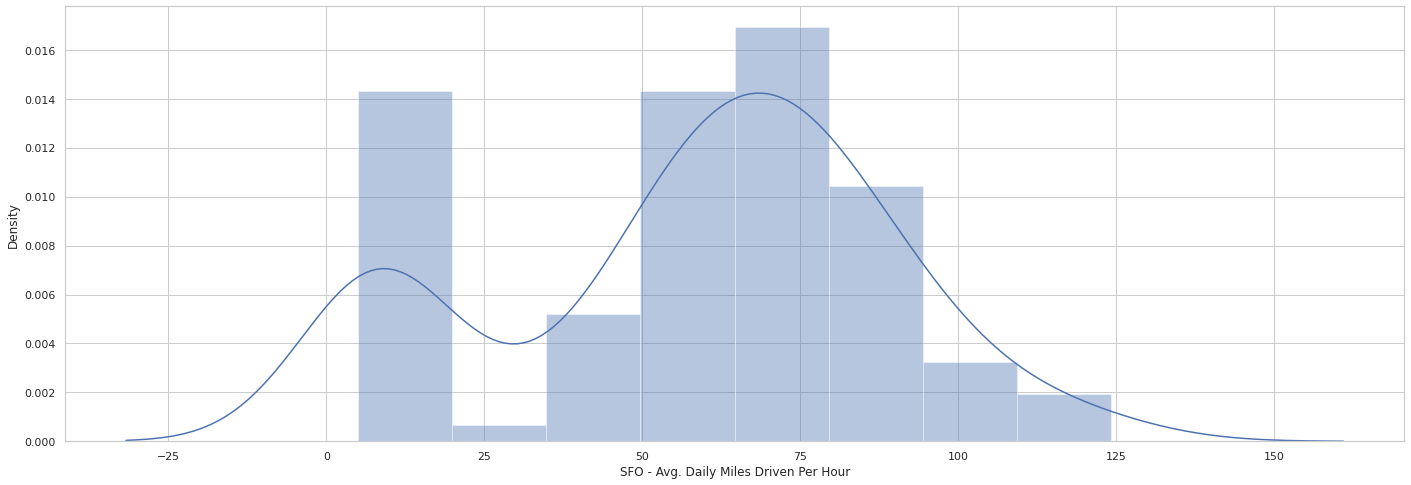

In [ ]:
# Draw the histogram of whole dataset
sns.set(style='whitegrid')
h_sfo = sns.distplot(df_sfo['SFO - Avg. Daily Miles Driven Per Hour'], bins = 8)

### Split into two groups, which one has marketing campaign and one has no marketing.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Histogram of Average Daily Mile Driven Per Hour at SFO cut by Marketing Campaign')

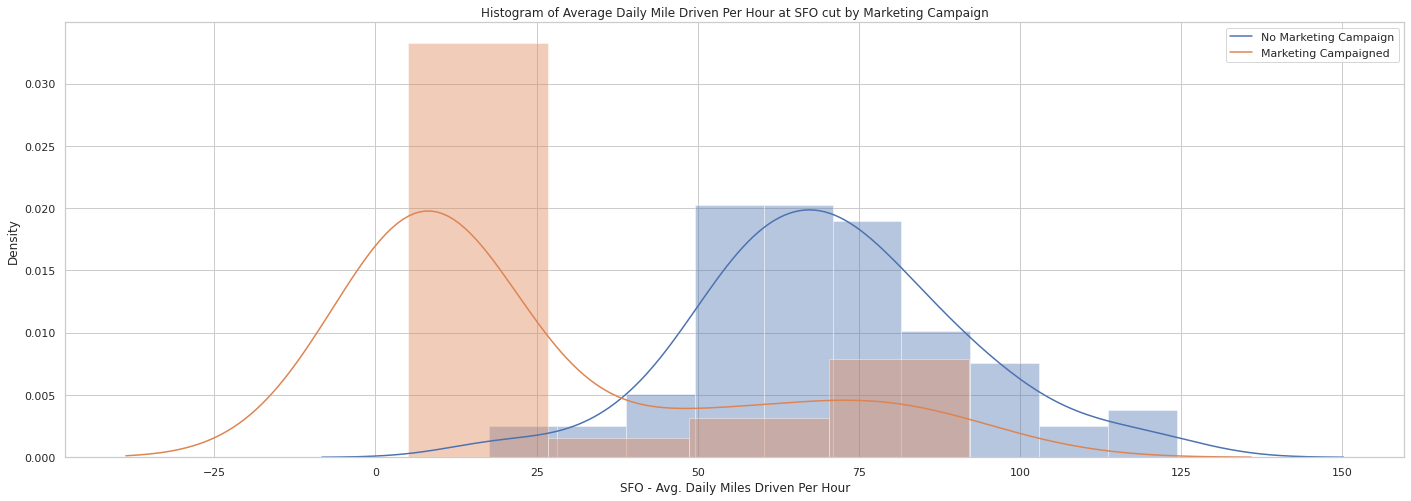

In [ ]:
# Split two groups
nocampaign = df_sfo['SFO - Avg. Daily Miles Driven Per Hour'].loc[df_sfo['Marketing_Campaign'] == 0]
campaigned = df_sfo['SFO - Avg. Daily Miles Driven Per Hour'].loc[df_sfo['Marketing_Campaign'] == 1]

# Draw the histogram of two groups 
sns.set(style='whitegrid')
ax = sns.distplot(nocampaign, hist = True)
ax = sns.distplot(campaigned, hist = True)
plt.legend(['No Marketing Campaign','Marketing Campaigned'])
plt.title('Histogram of Average Daily Mile Driven Per Hour at SFO cut by Marketing Campaign')

### Calculate p-value

In [ ]:
# Calculate p-value
stat, p = f_oneway(nocampaign, campaigned)
print('Statistics=%.4f, p=%.4f' % (stat, p))

# Decision
alpha = 0.05
if p > alpha:
	print('Same distributions (fail to reject H0)')
else:
	print('Different distributions (reject H0)')

Statistics=84.4600, p=0.0000
Different distributions (reject H0)


## LAX dataset

### Description of quantitative variables

In [ ]:
df_lax.describe()

,LAX - Avg. Daily Miles Driven Per Hour,Marketing_Campaign
count,103.000000,103.000000
mean,124.600406,0.291262
std,66.200234,0.456566
min,-18.555252,0.000000
25%,79.903888,0.000000
50%,122.806613,0.000000
75%,162.496199,1.000000
max,286.002490,1.000000


### Histogram

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


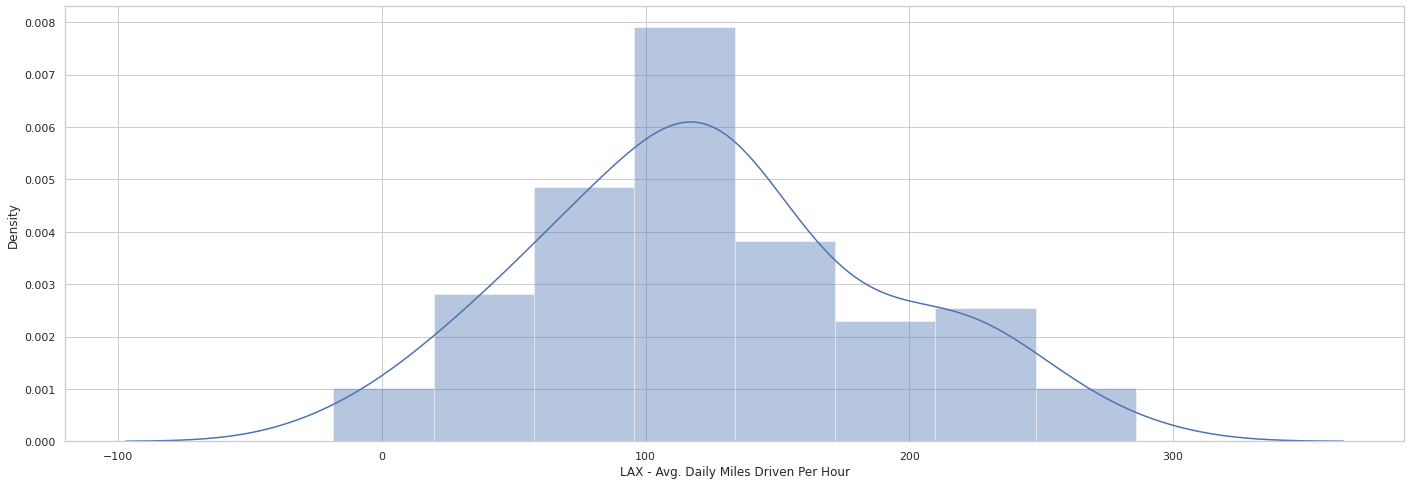

In [ ]:
# Draw the histogram of whole dataset
sns.set(style='whitegrid')
h_lax = sns.distplot(df_lax['LAX - Avg. Daily Miles Driven Per Hour'], bins = 8)

- There are negative values in Avg. Daily Miles Driven Per Hour, which does not make sense.

### Drop negative values and draw histogram of new dataset.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


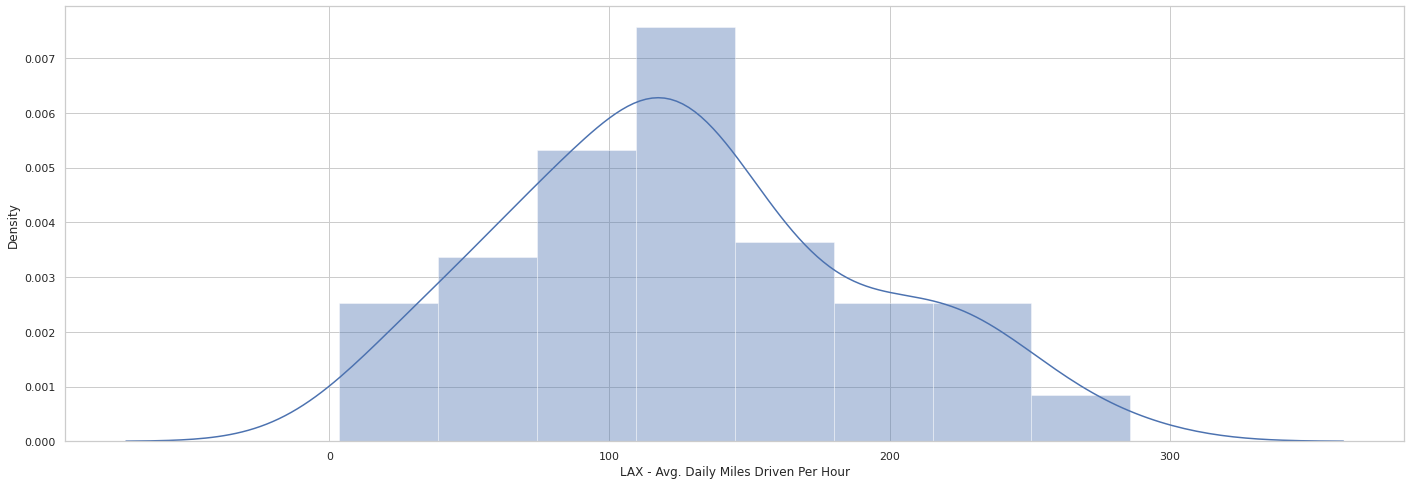

In [ ]:
# Drop negative value
df_lax_cleaned = df_lax[df_lax['LAX - Avg. Daily Miles Driven Per Hour']>=0]

# Replot the histogram of new dataset
sns.set(style='whitegrid')
h_lax = sns.distplot(df_lax_cleaned['LAX - Avg. Daily Miles Driven Per Hour'], bins = 8)

### Split into two groups, which one has marketing campaign and one has no marketing.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Histogram of Average Daily Mile Driven Per Hour at LAX cut by Marketing Campaign')

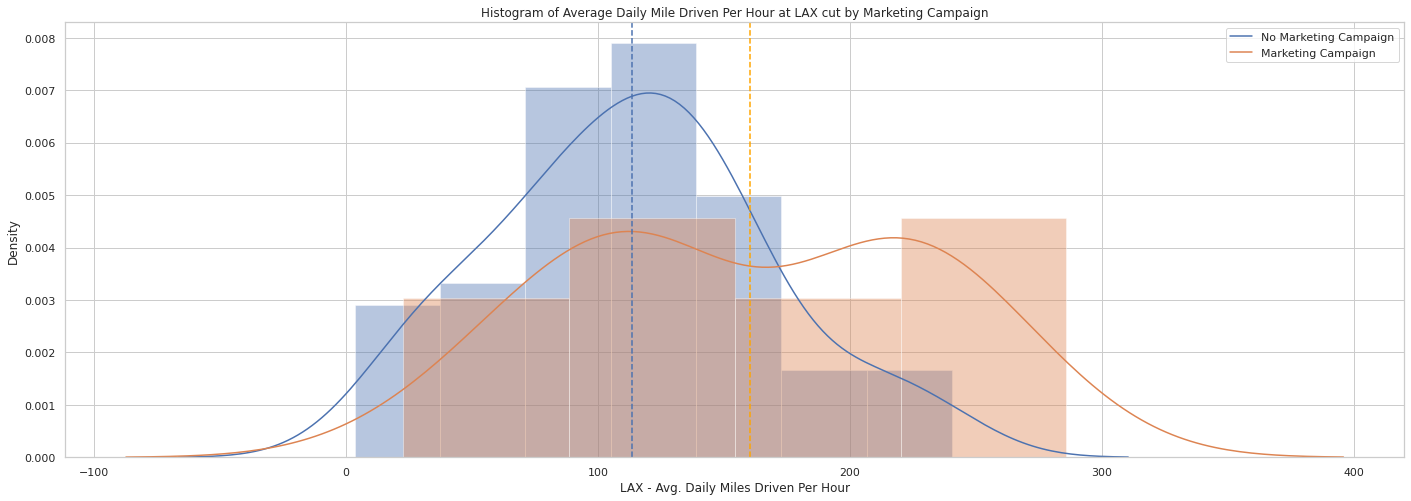

In [ ]:
# Split two groups
nocampaign_l = df_lax_cleaned['LAX - Avg. Daily Miles Driven Per Hour'].loc[df_lax_cleaned['Marketing_Campaign'] == 0]
campaigned_l = df_lax_cleaned['LAX - Avg. Daily Miles Driven Per Hour'].loc[df_lax_cleaned['Marketing_Campaign'] == 1]

# Draw the histogram of two groups 
sns.set(style='whitegrid')
ax = sns.distplot(nocampaign_l, hist = True)
ax = sns.distplot(campaigned_l, hist = True)
plt.axvline(np.mean(nocampaign_l), linestyle='--')
plt.axvline(np.mean(campaigned_l),color='orange', linestyle='--')
plt.legend(['No Marketing Campaign','Marketing Campaign'])
plt.title('Histogram of Average Daily Mile Driven Per Hour at LAX cut by Marketing Campaign')

In [ ]:
# Calculte p-value
stat_l, p_l = f_oneway(nocampaign_l, campaigned_l)
print('Statistics=%.4f, p=%.4f' % (stat_l, p_l))

# Decision
alpha = 0.05
if p_l > alpha:
	print('Same distributions (fail to reject H0)')
else:
	print('Different distributions (reject H0)')

Statistics=12.6911, p=0.0006
Different distributions (reject H0)


## Summary:
- We got both p-values as 0 for SFO, and LAX datasets, which indicates to **reject the null hypothesis.** The average daily miles driven per hour is not the same regardless of whether there is a marketing campaign or not for SFO and LAX datasets.
- However, from the histogram of SFO, which shows that the average daily miles driven per hour *with marketing campaign* **is lower than** the average daily miles driven per hour with *no marketing campaign*, the alternative hypothesis is not supported. We need more data(features) to investigate further the factors that increase the average daily miles driven per hour.
- From the histogram of LAX, we can see the mean value of the average daily miles driven per hour is higher when there is a marketing campaign. We can say that the marketing campaign increases the average daily miles driven per Uber driver.

- Other features that might affect the validation of this study:
  1. Competitor: other competitors(Lyft or Taxi) with lower prices or promotions.
  2. Transportation: public transportation(train or subway) around the airports.
  3. Weather: weather(raining or high temperature) around the neighborhood of the airport.



# Reference:
- Pedro M Duarte. (Sep 25, 2015). Get statistics for each group.
https://stackoverflow.com/questions/19384532/get-statistics-for-each-group-such-as-count-mean-etc-using-pandas-groupby
- shivsn. (Jul 9,2016). Remove special characters in pandas dataframe.
https://stackoverflow.com/questions/38277928/remove-special-characters-in-pandas-dataframe/38277932
- Seaborn. Visualizing regression models.
https://seaborn.pydata.org/tutorial/regression.html
- Aden Haussmann. (Jul 29, 2020). Polynomial Regression: The Only Introduction You’ll Need
https://towardsdatascience.com/polynomial-regression-the-only-introduction-youll-need-49a6fb2b86de
- Mr. T. (Jul 19, 2018). Mean, Median, Mode lines showing only in last graph in seaborn.
https://stackoverflow.com/questions/51417483/mean-median-mode-lines-showing-only-in-last-graph-in-seaborn
